In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

from sklearn.metrics import confusion_matrix
import itertools

#directories
import os
from os import listdir
from os.path import isfile, join

from skimage import color
from skimage import io
from sklearn.model_selection import train_test_split

from skimage import img_as_ubyte
import skimage.transform
import cv2
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
import keras
from keras.models import Model

from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense , Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.layers import GlobalAveragePooling2D
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D ,Dropout
# from keras.layers import 
# for saving model
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()                       
drive = GoogleDrive(gauth)

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
classes = ['ardhabaddhapadmottanasana','ekapadabakasana','natarajasana',
           'parivrttaardhachandrasana','parivrttasuryayantrasana','salambasirsasana',
           'svargadvijasana','tittibihasana','vrishchikasana','vyaghrasana']

In [0]:
drive_path = '/content/drive/My Drive/General Assembly/Data Science/Capstone/6 image classes/'
cat_1_folder  = drive_path + '500_ardhabaddhapadmottanasana/'
cat_2_folder  = drive_path + '500_ekapadabakasana/'
cat_3_folder  = drive_path + '500_natarajasana/'
cat_4_folder  = drive_path + '500_parivrttaardhachandrasana/'
cat_5_folder  = drive_path + '500_parivrttasuryayantrasana/'
cat_6_folder  = drive_path + '500_salambasirsasana/'
cat_7_folder  = drive_path + '500_svargadvijasana/'
cat_8_folder  = drive_path + '500_tittibihasana/'
cat_9_folder  = drive_path + '500_vrishchikasana/'
cat_10_folder = drive_path + '500_vyaghrasana/'

In [0]:
folders_path = [cat_1_folder,cat_2_folder,cat_3_folder, 
                cat_4_folder, cat_5_folder, cat_6_folder, 
                cat_7_folder, cat_8_folder, cat_9_folder, cat_10_folder ]

In [6]:
all_images =[]
for i,path in enumerate(folders_path):
    
    ls = []
    for f in listdir(path):
        if isfile(join(path, f)):
            if 'DS' not in f:
                if '._' not in f:
                    ls.append([path+f,f,classes[i]])
    # ls = [[path+f,f,classes[i]] for f in listdir(path) if isfile(join(path, f)) if ('DS' or '._' ) not in f ]
    print('{} ,numer of images for {} : {}'.format(i+1,classes[i],len(ls)))
    all_images.extend(ls)

1 ,numer of images for ardhabaddhapadmottanasana : 575
2 ,numer of images for ekapadabakasana : 570
3 ,numer of images for natarajasana : 570
4 ,numer of images for parivrttaardhachandrasana : 600
5 ,numer of images for parivrttasuryayantrasana : 551
6 ,numer of images for salambasirsasana : 591
7 ,numer of images for svargadvijasana : 574
8 ,numer of images for tittibihasana : 608
9 ,numer of images for vrishchikasana : 665
10 ,numer of images for vyaghrasana : 560


In [7]:
df =pd.DataFrame(all_images,columns=['image_path','image_name','category'])
print(df.shape)
df.head()

(5864, 3)


,image_path,image_name,category
0,/content/drive/My Drive/General Assembly/Data ...,ardhabaddhapadmottanasana_101.jpg,ardhabaddhapadmottanasana
1,/content/drive/My Drive/General Assembly/Data ...,ardhabaddhapadmottanasana_1010.jpg,ardhabaddhapadmottanasana
2,/content/drive/My Drive/General Assembly/Data ...,ardhabaddhapadmottanasana_1001.jpg,ardhabaddhapadmottanasana
3,/content/drive/My Drive/General Assembly/Data ...,ardhabaddhapadmottanasana_10.jpg,ardhabaddhapadmottanasana
4,/content/drive/My Drive/General Assembly/Data ...,ardhabaddhapadmottanasana_1001_2.jpg,ardhabaddhapadmottanasana


In [0]:
from sklearn.model_selection import train_test_split
train, tempt = train_test_split(df, train_size=0.6, shuffle = True, stratify = df.category)
valid, test  = train_test_split(tempt, test_size=0.5, shuffle = True, stratify = tempt.category)

In [9]:
size = (224,224)
train_batch_size = 32
batch_size = 16
epoch = 500

train_steps = math.ceil(train.shape[0]/train_batch_size)
valid_steps = math.ceil(valid.shape[0]/batch_size)
test_steps  = math.ceil(test.shape[0]/batch_size)
train_steps,valid_steps,test_steps

(110, 74, 74)

In [0]:
# we create two instances with the same arguments
data_gen_args = dict(rescale=1./255,
                    #  featurewise_center=True,
                    #  featurewise_std_normalization=True,
                     rotation_range=90,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range = 0.1,
                     horizontal_flip = True,
                     vertical_flip = True,
                     zoom_range=0.2)
dat_gen_args_test = dict(rescale=1./255)

In [11]:
train_generator = ImageDataGenerator(**data_gen_args).flow_from_dataframe(
    dataframe     = train,
    directory     = None,
    x_col         = 'image_path',
    y_col         = 'category',
    target_size   = size,
    color_mode    = 'rgb',
    classes       = classes,
    class_mode    = "categorical",
    batch_size    = train_batch_size,
    shuffle       = True,
    seed          = 27,
    save_format   = 'jpg',
    interpolation = "bicubic", 
    validate_filenames = True)

val_generator = ImageDataGenerator(**dat_gen_args_test).flow_from_dataframe(
    dataframe     = valid,
    directory     = None,
    x_col         = 'image_path',
    y_col         = 'category',
    target_size   = size,
    color_mode    = 'rgb',
    classes       = classes,
    class_mode    = "categorical",
    batch_size    = batch_size,
    shuffle       = True,
    seed          = 27,
    save_format   = 'jpg',
    interpolation = "bicubic", 
    validate_filenames = True)

test_generator = ImageDataGenerator(**dat_gen_args_test).flow_from_dataframe(
    dataframe     = test,
    directory     = None,
    x_col         = 'image_path',
    y_col         = 'category',
    target_size   = size,
    color_mode    = 'rgb',
    classes       = classes,
    class_mode    = "categorical",
    batch_size    = batch_size,
    shuffle       = False,
    seed          = 27,
    save_format   = 'jpg',
    interpolation = "bicubic", 
    validate_filenames = True)

Found 3518 validated image filenames belonging to 10 classes.
Found 1173 validated image filenames belonging to 10 classes.
Found 1173 validated image filenames belonging to 10 classes.


In [0]:
NASNetMobile_model = keras.applications.nasnet.NASNetMobile(input_shape=(224,224,3), include_top=False, weights='imagenet', input_tensor=None, pooling='avg', classes=10)


In [0]:
def plot_confusion_matrix(y_true, y_pred,cm):
    
    np.set_printoptions(precision=2)

    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest')
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' 
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()
    return ax






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/500
110/110 [==============================] - 1507s 14s/step - loss: 2.1174 - acc: 0.2195 - val_loss: 7.4953 - val_acc: 0.1850
Epoch 2/500
110/110 [==============================] - 117s 1s/step - loss: 1.5120 - acc: 0.4618 - val_loss: 2.4593 - val_acc: 0.3095
Epoch 3/500
110/110 [==============================] - 118s 1s/step - loss: 1.1253 - acc: 0.6379 - val_loss: 1.9098 - val_acc: 0.5422
Epoch 4/500
110/110 [==============================] - 118s 1s/step - loss: 0.7957 - acc: 0.7615 - val_loss: 2.2839 - val_acc: 0.5251
Epoch 5/500
110/110 [==============================] - 118s 1s/step - loss: 0.6649 - acc: 0.8084 - val_loss: 1.2355 - val_acc: 0.6957
Epoch 6/500
110/110 [==============================] - 119s 1s/step - loss: 0.5446 - acc: 0.8452 - val_loss: 2.3894 - val_acc: 0.5644
Epoch 7/500
110/110 [==============================] - 119s 1s/step - loss: 0.4584 - acc: 0.8693

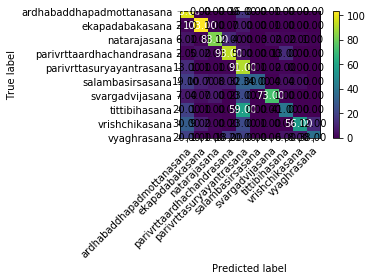

In [15]:
model = NASNetMobile_model

for layer in model.layers:
    layer.traiable = False

Dense_5 = Dense(2056,activation ='relu')(model.output)
Dense_4 = Dense(512,activation ='relu')(Dense_5)
Dense_3 = Dense(128,activation ='relu')(Dense_4)
Dense_2 = Dense(32,activation ='relu')(Dense_3)
output  = Dense(10,activation ='softmax')(Dense_2)


model = Model(inputs=model.inputs, outputs=output)
model.compile(Adam(lr = 0.001), loss = 'categorical_crossentropy',metrics =['accuracy'])

# model.summary()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

model.fit_generator(train_generator, steps_per_epoch = train_steps,
                validation_data=val_generator, validation_steps=valid_steps,
                epochs=epoch, verbose=1,callbacks=[es])
model.evaluate_generator(val_generator,steps=valid_steps )

#save model into directory # for kaggle will save to outputs and download manually
model.save(drive_path + 'NASNetmobile_model.h5')

test_generator.reset() #need to reset
predictions = model.predict_generator(test_generator,steps=test_steps,verbose=1)
pred_label=[np.argmax(image_class) for image_class in predictions]
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred_label_class = [labels[k] for k in pred_label]
# pred_label_class

test_generator.reset() #need to reset
y_true = test_generator.classes

print(len(y_true),len(pred_label))
cm = confusion_matrix(y_true,pred_label)
print(cm)
plot_confusion_matrix(y_true, pred_label,cm)


testing_df = pd.DataFrame(y_true,columns = ['true_label'])
testing_df['pred_label'] = pred_label
testing_df['result'] = ''
for i, rows in enumerate(testing_df.result):
    if testing_df.loc[i,'true_label'] == testing_df.loc[i,'pred_label']:
        testing_df.loc[i,'result']= 1
    elif testing_df.loc[i,'true_label'] != testing_df.loc[i,'pred_label']:
        testing_df.loc[i,'result']= 0

In [29]:
testing_df[(testing_df.result==0)  ] # 463 rows wrongly predicted

,true_label,pred_label,result
0,7,4,0
1,7,4,0
4,9,4,0
11,2,4,0
12,5,4,0
...,...,...,...
1164,7,0,0
1166,8,1,0
1170,9,4,0
1171,7,4,0


In [31]:
testing_df[(testing_df.result==0) ].pred_label.value_counts() # 463 rows wrongly predicted

4    189
0    119
3     39
1     32
7     30
2     22
8     14
9     13
6      5
Name: pred_label, dtype: int64

In [32]:
testing_df[(testing_df.result==0) & (testing_df.pred_label==0) ] # 119 rows wrongly predicted

,true_label,pred_label,result
15,5,0,0
18,8,0,0
22,9,0,0
23,9,0,0
24,4,0,0
...,...,...,...
1126,9,0,0
1128,8,0,0
1143,7,0,0
1150,7,0,0


In [33]:
testing_df[(testing_df.result==0) & (testing_df.pred_label==0) ].true_label.value_counts() # need to increase number of images for '7' and '5' ,'8', '9'

8    30
9    20
7    20
5    19
4    13
6     7
2     6
3     2
1     2
Name: true_label, dtype: int64

In [27]:
testing_df[(testing_df.result==0) & (testing_df.pred_label==4) ] # 189 rows wrongly predicted

,true_label,pred_label,result
0,7,4,0
1,7,4,0
4,9,4,0
11,2,4,0
12,5,4,0
...,...,...,...
1155,3,4,0
1162,7,4,0
1170,9,4,0
1171,7,4,0


In [28]:
testing_df[(testing_df.result==0) & (testing_df.pred_label==4) ].true_label.value_counts() # need to increase number of images for '7' and '5' 

7    59
5    32
8    23
6    23
9    20
0    16
1     7
3     5
2     4
Name: true_label, dtype: int64

In [26]:
testing_df[(testing_df.result==0)].true_label.value_counts() # need to increase number of images for '4' and '0' 

5    84
7    81
8    77
9    74
6    42
2    31
3    27
4    19
0    17
1    11
Name: true_label, dtype: int64

In [18]:
test

,image_path,image_name,category
4246,/content/drive/My Drive/General Assembly/Data ...,tittibhasana_35.jpg,tittibihasana
4340,/content/drive/My Drive/General Assembly/Data ...,tittibhasana_514.jpg,tittibihasana
407,/content/drive/My Drive/General Assembly/Data ...,ardhabaddhapadmottanasana_706.jpg,ardhabaddhapadmottanasana
2717,/content/drive/My Drive/General Assembly/Data ...,parivrttasuryayantrasana_651.jpg,parivrttasuryayantrasana
5835,/content/drive/My Drive/General Assembly/Data ...,vyaghrasana_72.jpg,vyaghrasana
...,...,...,...
265,/content/drive/My Drive/General Assembly/Data ...,ardhabaddhapadmottanasana_433.jpg,ardhabaddhapadmottanasana
1689,/content/drive/My Drive/General Assembly/Data ...,natarajasana_906.jpg,natarajasana
5461,/content/drive/My Drive/General Assembly/Data ...,vyaghrasana_263.jpg,vyaghrasana
4477,/content/drive/My Drive/General Assembly/Data ...,tittibhasana_74.jpg,tittibihasana


In [19]:
testing_df

,true_label,pred_label,result
0,7,4,0
1,7,4,0
2,0,0,1
3,4,4,1
4,9,4,0
...,...,...,...
1168,0,0,1
1169,2,2,1
1170,9,4,0
1171,7,4,0


In [22]:
test

,image_path,image_name,category
4246,/content/drive/My Drive/General Assembly/Data ...,tittibhasana_35.jpg,tittibihasana
4340,/content/drive/My Drive/General Assembly/Data ...,tittibhasana_514.jpg,tittibihasana
407,/content/drive/My Drive/General Assembly/Data ...,ardhabaddhapadmottanasana_706.jpg,ardhabaddhapadmottanasana
2717,/content/drive/My Drive/General Assembly/Data ...,parivrttasuryayantrasana_651.jpg,parivrttasuryayantrasana
5835,/content/drive/My Drive/General Assembly/Data ...,vyaghrasana_72.jpg,vyaghrasana
...,...,...,...
265,/content/drive/My Drive/General Assembly/Data ...,ardhabaddhapadmottanasana_433.jpg,ardhabaddhapadmottanasana
1689,/content/drive/My Drive/General Assembly/Data ...,natarajasana_906.jpg,natarajasana
5461,/content/drive/My Drive/General Assembly/Data ...,vyaghrasana_263.jpg,vyaghrasana
4477,/content/drive/My Drive/General Assembly/Data ...,tittibhasana_74.jpg,tittibihasana


In [34]:
test.reset_index(inplace = True,drop=True)
test

,image_path,image_name,category
0,/content/drive/My Drive/General Assembly/Data ...,tittibhasana_35.jpg,tittibihasana
1,/content/drive/My Drive/General Assembly/Data ...,tittibhasana_514.jpg,tittibihasana
2,/content/drive/My Drive/General Assembly/Data ...,ardhabaddhapadmottanasana_706.jpg,ardhabaddhapadmottanasana
3,/content/drive/My Drive/General Assembly/Data ...,parivrttasuryayantrasana_651.jpg,parivrttasuryayantrasana
4,/content/drive/My Drive/General Assembly/Data ...,vyaghrasana_72.jpg,vyaghrasana
...,...,...,...
1168,/content/drive/My Drive/General Assembly/Data ...,ardhabaddhapadmottanasana_433.jpg,ardhabaddhapadmottanasana
1169,/content/drive/My Drive/General Assembly/Data ...,natarajasana_906.jpg,natarajasana
1170,/content/drive/My Drive/General Assembly/Data ...,vyaghrasana_263.jpg,vyaghrasana
1171,/content/drive/My Drive/General Assembly/Data ...,tittibhasana_74.jpg,tittibihasana


In [0]:
combine_test = pd.concat([test,testing_df], axis = 1)

In [36]:
combine_test

,image_path,image_name,category,true_label,pred_label,result
0,/content/drive/My Drive/General Assembly/Data ...,tittibhasana_35.jpg,tittibihasana,7,4,0
1,/content/drive/My Drive/General Assembly/Data ...,tittibhasana_514.jpg,tittibihasana,7,4,0
2,/content/drive/My Drive/General Assembly/Data ...,ardhabaddhapadmottanasana_706.jpg,ardhabaddhapadmottanasana,0,0,1
3,/content/drive/My Drive/General Assembly/Data ...,parivrttasuryayantrasana_651.jpg,parivrttasuryayantrasana,4,4,1
4,/content/drive/My Drive/General Assembly/Data ...,vyaghrasana_72.jpg,vyaghrasana,9,4,0
...,...,...,...,...,...,...
1168,/content/drive/My Drive/General Assembly/Data ...,ardhabaddhapadmottanasana_433.jpg,ardhabaddhapadmottanasana,0,0,1
1169,/content/drive/My Drive/General Assembly/Data ...,natarajasana_906.jpg,natarajasana,2,2,1
1170,/content/drive/My Drive/General Assembly/Data ...,vyaghrasana_263.jpg,vyaghrasana,9,4,0
1171,/content/drive/My Drive/General Assembly/Data ...,tittibhasana_74.jpg,tittibihasana,7,4,0


In [0]:
combine_test.to_csv(drive_path +'NasNetmobile_test_df.csv')

In [39]:
drive_path

'/content/drive/My Drive/General Assembly/Data Science/Capstone/6 image classes/'